In [514]:
# Author: Andrés Felipe Ortega Montoya
# Last modified: August 19th, 2021

# Fuzzy Inference System for Cross-Matching Blood Compatibility Test
# Artificial Intelligence course
# Professor Olga Lucia Quintero

# Import 

In [515]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from random import gauss

# Fuzzy Inference System for Cross-Matching Blood Compatibility Test 

### Input

`Cell I` $\in \mathbb{Z} \cap [0, 4]$

`Cell II` $\in \mathbb{Z} \cap [0, 4]$

`Cell III` $\in \mathbb{Z} \cap [0, 4]$

In [516]:
# Inputs
cell_input = [3, 0, 3]

###  Domain

In [517]:
# Inputs
max_score = 4 #[0,x]
cell_name = ["Cell " + id for id in ["I", "II", "III"]]
cell_input = dict(zip(cell_name, cell_input))
cell = {name: ctrl.Antecedent(np.arange(0, 4, 0.01), name) for name in cell_name}

# Output
antigen_name = ["D", "C", "E", "c", "e", "Cw", #Rh-hr
            "K", "k", "Kpa", "Kpb", "Jsb", #Kell, Jsa ommited for lack of information
            "Fya", "Fyb", #Duffy
            "Jka", "Jkb", #Kidd
            "Lea", "Leb", #Lewis
            "P1", #P
            "M", "N", "S", "s", #MNS
            "Lua", "Lub", #Luth
            "Xga" #Xg
]
antigen = {name : ctrl.Consequent(np.arange(0, 1, 0.01), name) for name in antigen_name} 

### Membership functions

In [518]:
# 68–95–99.7 rule
three_sd = 3

def gauss_parameters(mean, zero_value):
    sigma = np.abs(zero_value - mean) / three_sd
    return mean, sigma

#f=sig(x) centered in b
def sigmoid_parameters(x, f, b):
    c = -np.log((1 - f) / f) / (x - b)
    return b, c

##### Linguistic Categories

In [519]:
#All red blood cells (RBCs) are at the bottom of the tube, no agglutination 
b, c = sigmoid_parameters(1, 0.005, 0.5) #b: center, c: steepness 
for name in cell:
    cell[name][0] = fuzz.sigmf(x=cell[name].universe, b=b, c=c)

#Everything in between
for name in cell:
    for score in range(1,max_score): #[1,x)
        mean, sigma = gauss_parameters(score, score + 1.5)
        cell[name][score] = fuzz.gaussmf(x=cell[name].universe, mean=score, sigma=sigma)

#All RBCs are agglutinated and form a red line on the surface of the gel
b, c = sigmoid_parameters(max_score-1, 0.005, max_score-0.5) #b: center, c: steepness 
for name in cell:
    cell[name][max_score] = fuzz.sigmf(x=cell[name].universe, b=b, c=c)

for name in antigen:
    #b, c = sigmoid_parameters(0.15, 0.005, 0.05) #b: center, c: steepness
    #antigen[name]['Impossible'] = fuzz.sigmf(x=antigen[name].universe, b=b, c=c)
    mean, sigma = gauss_parameters(0, 0.15)
    antigen[name]['Impossible'] = fuzz.gaussmf(x=antigen[name].universe, mean=mean, sigma=sigma)
    mean, sigma = gauss_parameters(0.25, 0.5)
    antigen[name]['Unlikely'] = fuzz.gaussmf(x=antigen[name].universe, mean=mean, sigma=sigma)
    mean, sigma = gauss_parameters(0.6, 1)
    antigen[name]['Possible'] = fuzz.gaussmf(x=antigen[name].universe, mean=mean, sigma=sigma)
    b, c = sigmoid_parameters(0.85, 0.005, 0.9) #b: center, c: steepness 
    antigen[name]['Very likely'] = fuzz.sigmf(x=antigen[name].universe, b=b, c=c)

### Utils

### Fuzzy sets

C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


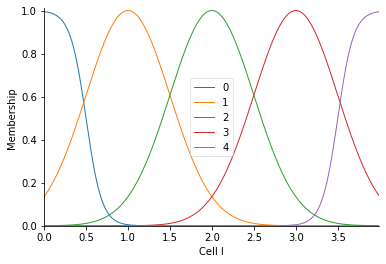

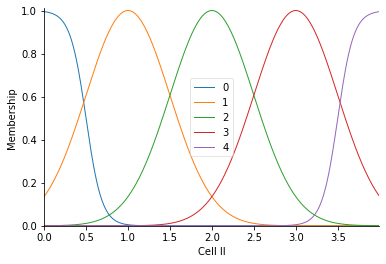

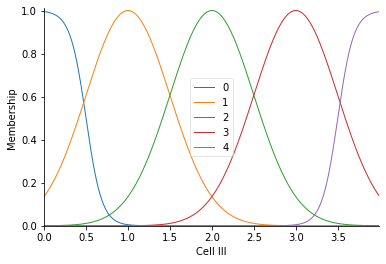

In [520]:
for name in cell:
    cell[name].view()

### Decision rules

In [521]:
antigen_table = [
    #D, C, E, c, e, Cw / K, k, Kpa, Kpb, Jsb / Fya, Fyb / Jka, Jkb / Lea, Leb / P1 / M, N, S, s / Lua, Lub / Xga
    [1, 1, 0, 0, 1,  0,  1, 1,   0,   1,   1,    1,   1,    1,   0,    0,   1,   1,  1, 0, 1, 0,    0,   1,    1],
    [1, 0, 1, 1, 0,  0,  0, 1,   0,   1,   1,    1,   0,    1,   1,    1,   0,   1,  0, 1, 0, 1,    0,   1,    1],
    [1, 1, 0, 0, 1,  0,  0, 1,   0,   1,   1,    1,   1,    1,   1,    0,   1,   0,  1, 1, 1, 1,    0,   1,    0]
]

antigen_dic = {}
for i, row in enumerate(antigen_table):
    antigen_dic[cell_name[i]] = dict(zip(antigen_name, row))

rules = []

c1, c2, c3 = cell_name[0], cell_name[1], cell_name[2]
for a_name in antigen_name:
    if antigen_dic[c1][a_name] == 0 and antigen_dic[c2][a_name] == 0 and antigen_dic[c3][a_name] == 0:
        for i in range(5):
            rules.append(ctrl.Rule(cell[c1][i] | cell[c2][i] | cell[c3][i], antigen[a_name]['Possible']))
    if antigen_dic[c1][a_name] == 1:
        rules.append(ctrl.Rule(cell[c1][0], antigen[a_name]['Impossible']))
    if antigen_dic[c2][a_name] == 1:
        rules.append(ctrl.Rule(cell[c2][0], antigen[a_name]['Impossible']))
    if antigen_dic[c3][a_name] == 1:
        rules.append(ctrl.Rule(cell[c3][0], antigen[a_name]['Impossible']))

    if antigen_dic[c1][a_name] == 0 and antigen_dic[c2][a_name] == 0 and antigen_dic[c3][a_name] == 1:
        rules.append(ctrl.Rule(cell[c3][1] | cell[c3][2], antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule(cell[c3][3], antigen[a_name]['Possible']))
        rules.append(ctrl.Rule(cell[c3][4], antigen[a_name]['Very likely']))
    if antigen_dic[c1][a_name] == 0 and antigen_dic[c2][a_name] == 1 and antigen_dic[c3][a_name] == 0:
        rules.append(ctrl.Rule(cell[c2][1] | cell[c2][2], antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule(cell[c2][3], antigen[a_name]['Possible']))
        rules.append(ctrl.Rule(cell[c2][4], antigen[a_name]['Very likely']))
    if antigen_dic[c1][a_name] == 1 and antigen_dic[c2][a_name] == 0 and antigen_dic[c3][a_name] == 0:
        rules.append(ctrl.Rule(cell[c1][1] | cell[c1][2], antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule(cell[c1][3], antigen[a_name]['Possible']))
        rules.append(ctrl.Rule(cell[c1][4], antigen[a_name]['Very likely']))

    if antigen_dic[c1][a_name] == 0 and antigen_dic[c2][a_name] == 1 and antigen_dic[c3][a_name] == 1:
        rules.append(ctrl.Rule((cell[c2][1] & cell[c3][1]) |
                               (cell[c2][1] & cell[c3][2]) |
                               (cell[c2][2] & cell[c3][1]),
                               antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule((cell[c2][2] & cell[c3][2]) |
                               (cell[c2][2] & cell[c3][3]) |
                               (cell[c2][3] & cell[c3][2]) |
                               (cell[c2][1] & cell[c3][3]) |
                               (cell[c2][3] & cell[c3][1]),
                               antigen[a_name]['Possible']))
        rules.append(ctrl.Rule((cell[c2][3] | cell[c2][4]) &
                               (cell[c3][3] | cell[c3][4]),
                               antigen[a_name]['Very likely']))
    if antigen_dic[c1][a_name] == 1 and antigen_dic[c2][a_name] == 0 and antigen_dic[c3][a_name] == 1:
        rules.append(ctrl.Rule((cell[c1][1] & cell[c3][1]) |
                               (cell[c1][1] & cell[c3][2]) |
                               (cell[c1][2] & cell[c3][1]),
                               antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule((cell[c1][2] & cell[c3][2]) |
                               (cell[c1][2] & cell[c3][3]) |
                               (cell[c1][3] & cell[c3][2]) |
                               (cell[c1][1] & cell[c3][3]) |
                               (cell[c1][3] & cell[c3][1]),
                               antigen[a_name]['Possible']))
        rules.append(ctrl.Rule((cell[c1][3] | cell[c1][4]) &
                               (cell[c3][3] | cell[c3][4]),
                               antigen[a_name]['Very likely']))
    if antigen_dic[c1][a_name] == 1 and antigen_dic[c2][a_name] == 1 and antigen_dic[c3][a_name] == 0:
        rules.append(ctrl.Rule((cell[c1][1] & cell[c2][1]) |
                               (cell[c1][1] & cell[c2][2]) |
                               (cell[c1][2] & cell[c2][1]),
                               antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule((cell[c1][2] & cell[c2][2]) |
                               (cell[c1][2] & cell[c2][3]) |
                               (cell[c1][3] & cell[c2][2]) |
                               (cell[c1][1] & cell[c2][3]) |
                               (cell[c1][3] & cell[c2][1]),
                               antigen[a_name]['Possible']))
        rules.append(ctrl.Rule((cell[c1][3] | cell[c1][4]) &
                               (cell[c2][3] | cell[c2][4]),
                               antigen[a_name]['Very likely']))

    if antigen_dic[c1][a_name] == 1 and antigen_dic[c2][a_name] == 1 and antigen_dic[c3][a_name] == 1:
        rules.append(ctrl.Rule((cell[c1][1] & cell[c2][1] & cell[c3][1]) |
                               (cell[c1][1] & cell[c2][1] & cell[c3][2]) |
                               (cell[c1][1] & cell[c2][2] & cell[c3][1]) |
                               (cell[c1][2] & cell[c2][1] & cell[c3][1]),
                               antigen[a_name]['Unlikely']))
        rules.append(ctrl.Rule((cell[c1][1] & cell[c2][2] & cell[c3][2]) |
                               (cell[c1][2] & cell[c2][1] & cell[c3][2]) |
                               (cell[c1][2] & cell[c2][2] & cell[c3][1]) |
                               (cell[c1][2] & cell[c2][2] & cell[c3][2]) |
                               (cell[c1][1] & cell[c2][3] & cell[c3][3]) |
                               (cell[c1][3] & cell[c2][1] & cell[c3][3]) |
                               (cell[c1][3] & cell[c2][3] & cell[c3][1]) |
                               (cell[c1][2] & cell[c2][3] & cell[c3][3]) |
                               (cell[c1][3] & cell[c2][2] & cell[c3][3]) |
                               (cell[c1][3] & cell[c2][3] & cell[c3][2]),
                                antigen[a_name]['Possible']))
        rules.append(ctrl.Rule((cell[c1][3] | cell[c1][4]) & (cell[c2][3] | cell[c2][4]) & (cell[c3][3] | cell[c3][4]), antigen[a_name]['Very likely']))

score_ctrll = ctrl.ControlSystem(rules)

# Final Veredict

C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Orfy\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backe

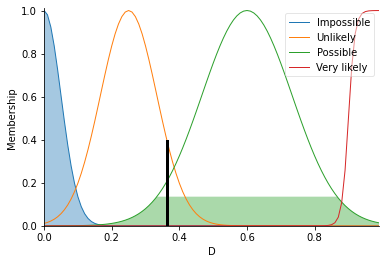

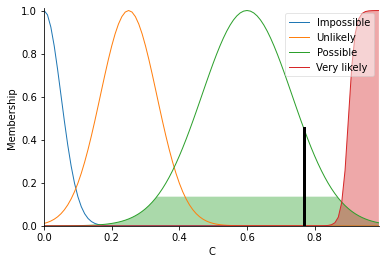

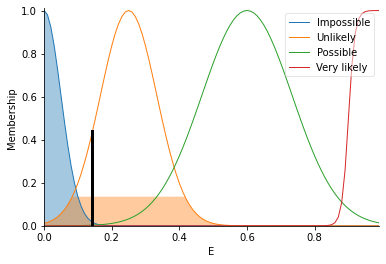

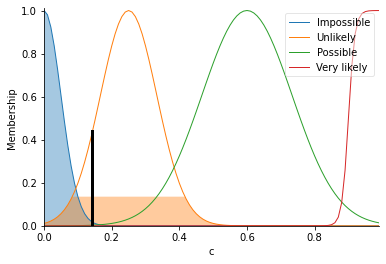

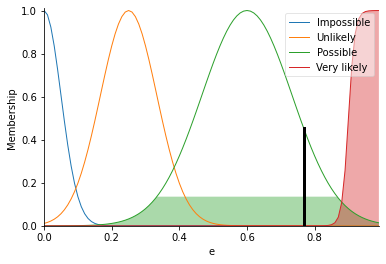

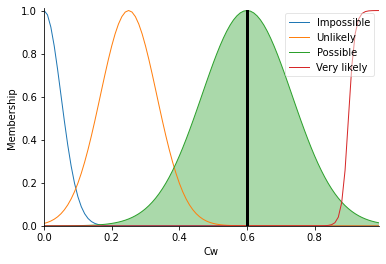

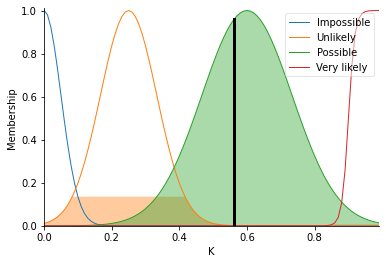

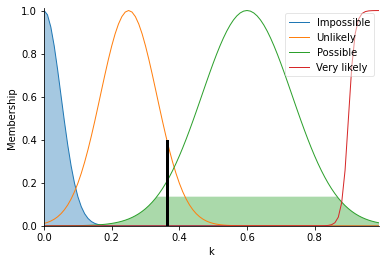

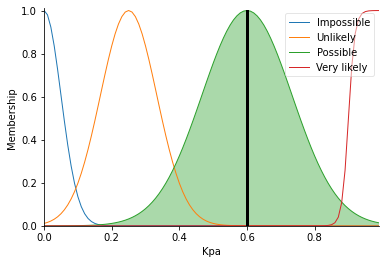

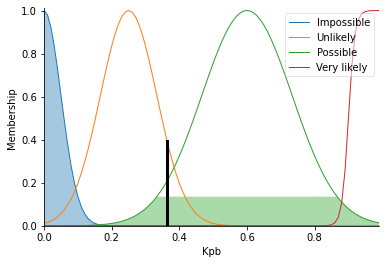

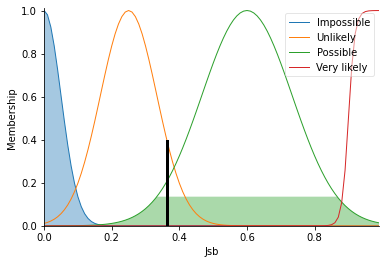

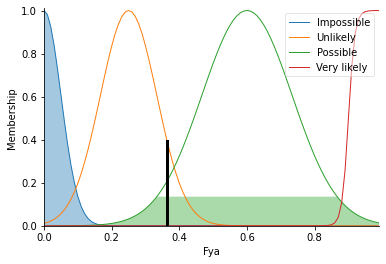

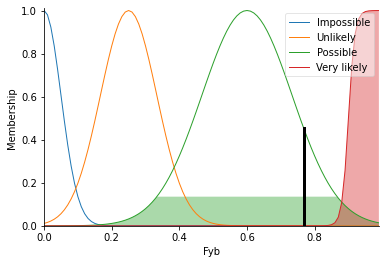

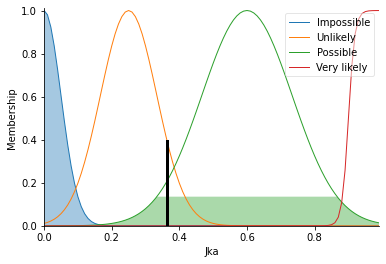

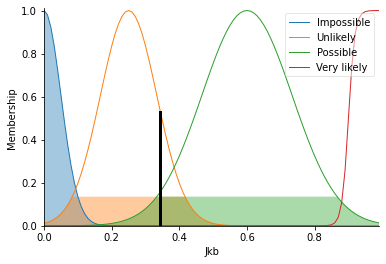

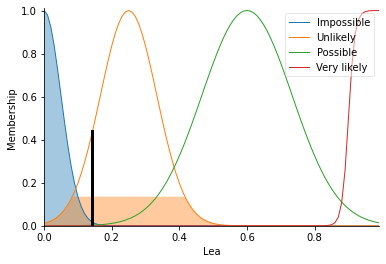

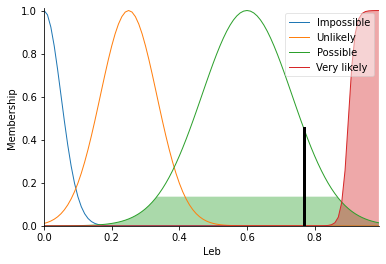

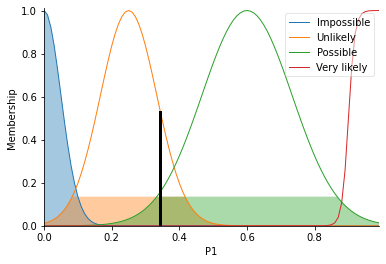

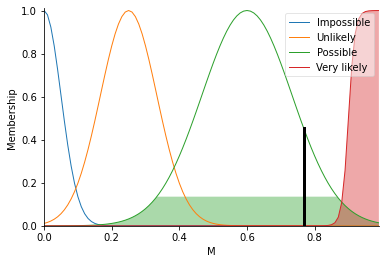

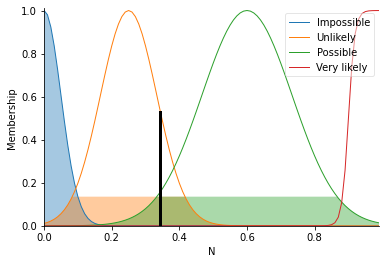

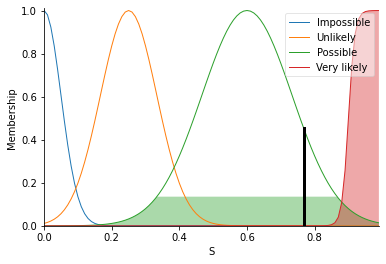

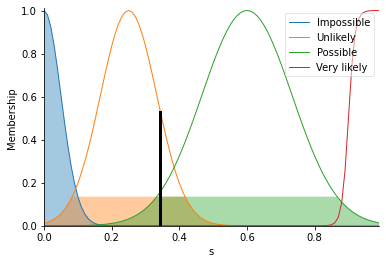

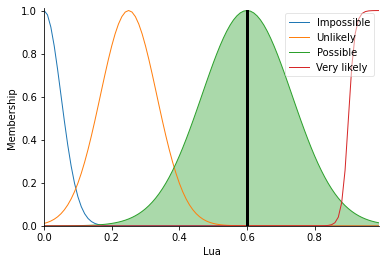

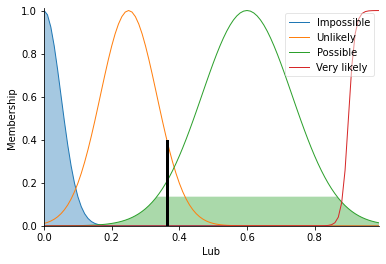

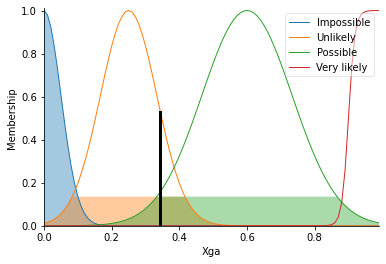

In [522]:
antigen_score = ctrl.ControlSystemSimulation(score_ctrl)
for name, score in cell_input.items():
    antigen_score.input[name] = score
antigen_score.compute()

#print(antigen_score.output)

for name in antigen:
    antigen[name].view(sim=antigen_score)